## Demonstrate full circle wide field imaging

This include prediction of components, inversion, point source fitting. We will compare the output images with the input models, looking for closeness in flux and position.

In [2]:
% matplotlib inline

import os
import sys

sys.path.append(os.path.join('..', '..'))

from data_models.parameters import arl_path
results_dir = arl_path('test_results')

from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (10.0, 10.0)
pylab.rcParams['image.cmap'] = 'rainbow'


from matplotlib import pyplot as plt

import numpy

from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy import units as u
from astropy.wcs.utils import pixel_to_skycoord

from data_models.polarisation import PolarisationFrame

from libs.image.iterators import image_raster_iter

from wrappers.serial.visibility.base import create_visibility
from wrappers.serial.visibility.operations import sum_visibility
from wrappers.serial.visibility.iterators import vis_timeslices, vis_wslices
from wrappers.serial.simulation.testing_support import create_named_configuration
from wrappers.serial.skycomponent.operations import create_skycomponent, find_skycomponents, \
    find_nearest_skycomponent, insert_skycomponent
from wrappers.serial.image.operations import show_image, export_image_to_fits, qa_image, smooth_image
from wrappers.serial.simulation.testing_support import create_named_configuration
from wrappers.serial.imaging.base import advise_wide_field, create_image_from_visibility, \
    predict_skycomponent_visibility

# Use workflows for imaging
from wrappers.arlexecute.execution_support.arlexecute import arlexecute
from workflows.shared.imaging.imaging_shared import imaging_contexts
from workflows.arlexecute.imaging.imaging_arlexecute import predict_list_arlexecute_workflow, \
    invert_list_arlexecute_workflow
import logging

log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))


Construct the SKA1-LOW core configuration

In [3]:
arlexecute.set_client(use_dask=True)

Using selector: KqueueSelector
Using selector: KqueueSelector


In [4]:
lowcore = create_named_configuration('LOWBD2-CORE')

We create the visibility. This just makes the uvw, time, antenna1, antenna2, weight columns in a table

In [5]:
times = numpy.array([-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0]) * (numpy.pi / 12.0)
frequency = numpy.array([1e8])
channel_bandwidth = numpy.array([1e6])
reffrequency = numpy.max(frequency)
phasecentre = SkyCoord(ra=+15.0 * u.deg, dec=-45.0 * u.deg, frame='icrs', equinox='J2000')
vt = create_visibility(lowcore, times, frequency, channel_bandwidth=channel_bandwidth,
                       weight=1.0, phasecentre=phasecentre, 
                       polarisation_frame=PolarisationFrame('stokesI'))

create_visibility: 95865 rows, 0.010 GB


In [6]:
advice = advise_wide_field(vt, wprojection_planes=1)

advise_wide_field: Maximum wavelength 2.998 (meters)
advise_wide_field: Minimum wavelength 2.998 (meters)
advise_wide_field: Maximum baseline 262.6 (wavelengths)
advise_wide_field: Station/antenna diameter 35.0 (meters)
advise_wide_field: Primary beam 0.085655 (rad) 4.908 (deg)
advise_wide_field: Image field of view 0.513930 (rad) 29.446 (deg)
advise_wide_field: Synthesized beam 0.003808 (rad) 0.218 (deg)
advise_wide_field: Cellsize 0.001269 (rad) 0.073 (deg)
advice_wide_field: Npixels per side = 405
advice_wide_field: Npixels (power of 2, 3) per side = 512
advice_wide_field: W sampling for full image = 0.2 (wavelengths)
advice_wide_field: W sampling for primary beam = 8.7 (wavelengths)
advice_wide_field: Time sampling for full image = 25.2 (s)
advice_wide_field: Time sampling for primary beam = 908.6 (s)
advice_wide_field: Frequency sampling for full image = 29212.6 (Hz)
advice_wide_field: Frequency sampling for primary beam = 1051653.8 (Hz)
advice_wide_field: Number of planes in w st

Fill in the visibility with exact calculation of a number of point sources

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 999999.99999 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
Spacing in pixels = 32
Component at (240.000000, 16.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    (4.74378292, -51.0209895)>
insert_skycomponent: Using insert method Nearest
Component at (208.000000, 16.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    (7.66144755, -51.22149637)>
insert_skycomponent: Using insert method Nearest
Component at (176.000000, 16.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    (10.5917361, -51.35530369)>
insert_skycomponent: Using insert method Nearest
Component

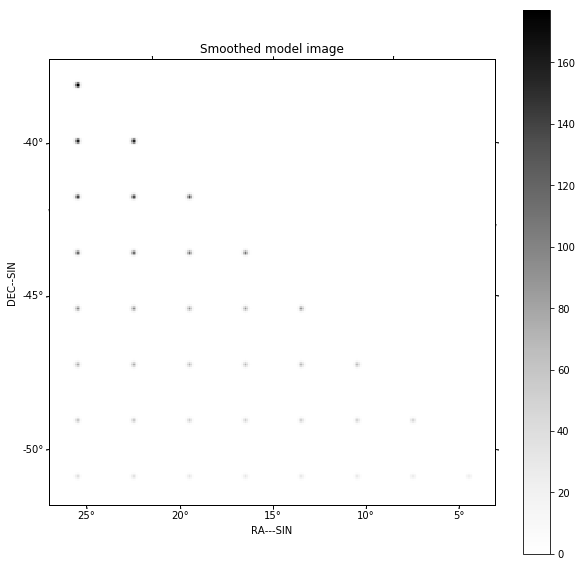

In [7]:
vt.data['vis'] *= 0.0
npixel=256

model = create_image_from_visibility(vt, npixel=npixel, cellsize=0.001, nchan=1, 
                                     polarisation_frame=PolarisationFrame('stokesI'))
centre = model.wcs.wcs.crpix-1
spacing_pixels = npixel // 8
log.info('Spacing in pixels = %s' % spacing_pixels)
spacing = model.wcs.wcs.cdelt * spacing_pixels
locations = [-3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5]

original_comps = []
# We calculate the source positions in pixels and then calculate the
# world coordinates to put in the skycomponent description
for iy in locations:
    for ix in locations:
        if ix >= iy:
            p = int(round(centre[0] + ix * spacing_pixels * numpy.sign(model.wcs.wcs.cdelt[0]))), \
                int(round(centre[1] + iy * spacing_pixels * numpy.sign(model.wcs.wcs.cdelt[1])))
            sc = pixel_to_skycoord(p[0], p[1], model.wcs)
            log.info("Component at (%f, %f) [0-rel] %s" % (p[0], p[1], str(sc)))
            flux = numpy.array([[100.0 + 2.0 * ix + iy * 20.0]])
            comp = create_skycomponent(flux=flux, frequency=frequency, direction=sc, 
                                       polarisation_frame=PolarisationFrame('stokesI'))
            original_comps.append(comp)
            insert_skycomponent(model, comp)

predict_skycomponent_visibility(vt, original_comps)

        
cmodel = smooth_image(model) 
show_image(cmodel)
plt.title("Smoothed model image")
plt.show()

Check that the skycoordinate and image coordinate system are consistent by finding the point sources.

find_skycomponents: Finding components in Image by segmentation
find_skycomponents: Identified 36 segments


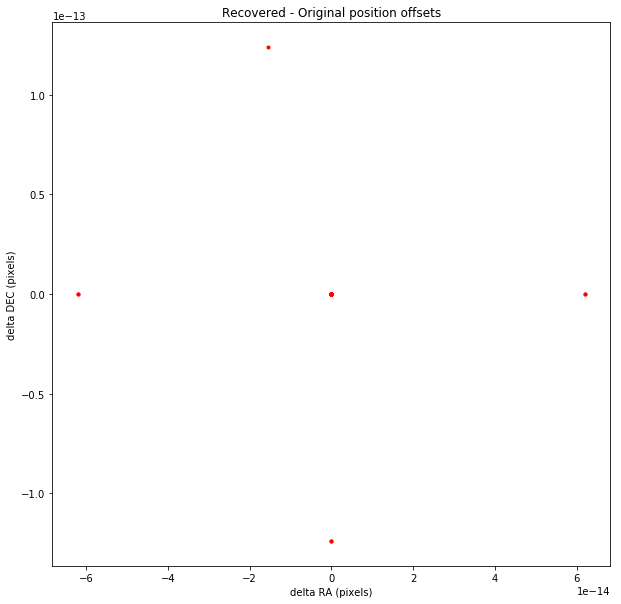

In [8]:
comps = find_skycomponents(cmodel, fwhm=1.0, threshold=10.0, npixels=5)
plt.clf()
for i in range(len(comps)):
    ocomp, sep = find_nearest_skycomponent(comps[i].direction, original_comps)
    plt.plot((comps[i].direction.ra.value  - ocomp.direction.ra.value)/cmodel.wcs.wcs.cdelt[0], 
             (comps[i].direction.dec.value - ocomp.direction.dec.value)/cmodel.wcs.wcs.cdelt[1], 
             '.', color='r')  

plt.xlabel('delta RA (pixels)')
plt.ylabel('delta DEC (pixels)')
plt.title("Recovered - Original position offsets")
plt.show()

Predict the visibility using the different approaches.

In [9]:
contexts = imaging_contexts().keys()
print(contexts)

dict_keys(['2d', 'facets', 'facets_timeslice', 'facets_wstack', 'timeslice', 'wstack'])


Processing context 2d
create_visibility: 95865 rows, 0.010 GB


/Users/timcornwell/anaconda/envs/arlenv/lib/python3.6/site-packages/distributed/worker.py:840: UserWarning: Large object of size 10.75 MB detected in task graph: 
  (<data_models.memory_data_models.Visibility object ... x11a199510>, 1)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s))


arlexecute.compute: Execution using Dask took 2.355 seconds
arlexecute.compute: Execution using Dask took 2.355 seconds


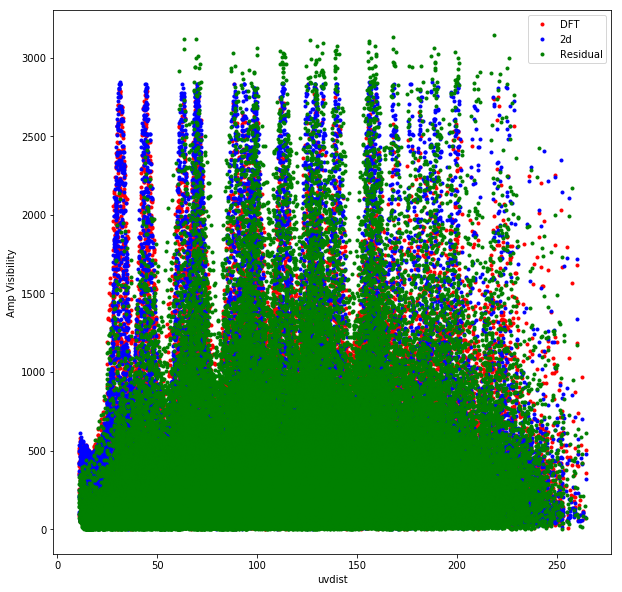

Processing context facets
create_visibility: 95865 rows, 0.010 GB
arlexecute.compute: Execution using Dask took 17.647 seconds
arlexecute.compute: Execution using Dask took 17.647 seconds


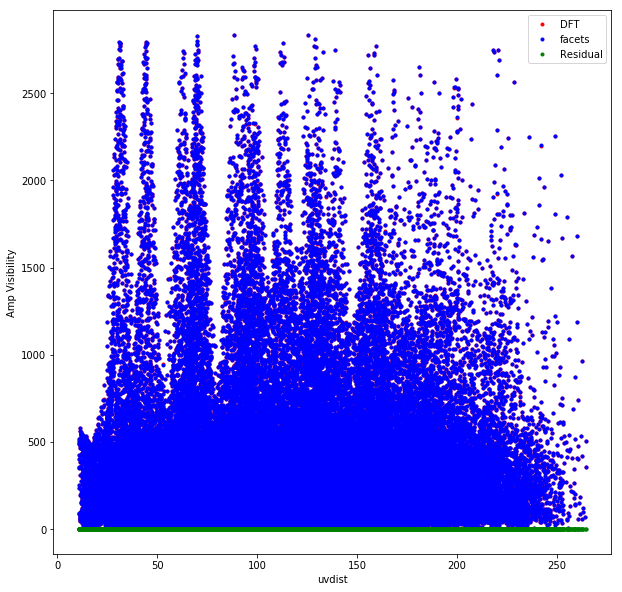

Processing context timeslice
create_visibility: 95865 rows, 0.010 GB
arlexecute.compute: Execution using Dask took 3.928 seconds
arlexecute.compute: Execution using Dask took 3.928 seconds


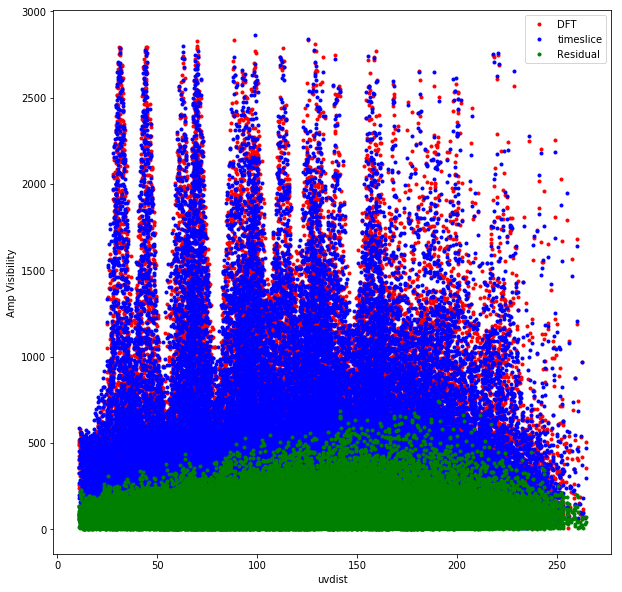

Processing context wstack
create_visibility: 95865 rows, 0.010 GB
arlexecute.compute: Execution using Dask took 2.563 seconds
arlexecute.compute: Execution using Dask took 2.563 seconds


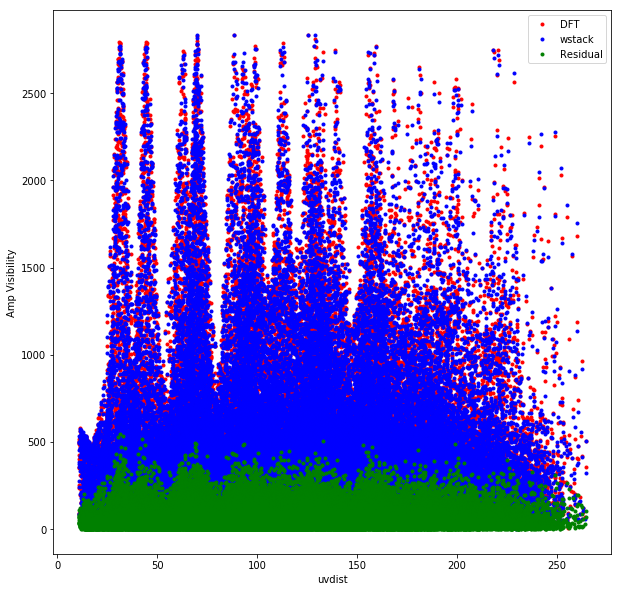

Processing context wprojection
create_visibility: 95865 rows, 0.010 GB
arlexecute.compute: Execution using Dask took 10.035 seconds
arlexecute.compute: Execution using Dask took 10.035 seconds


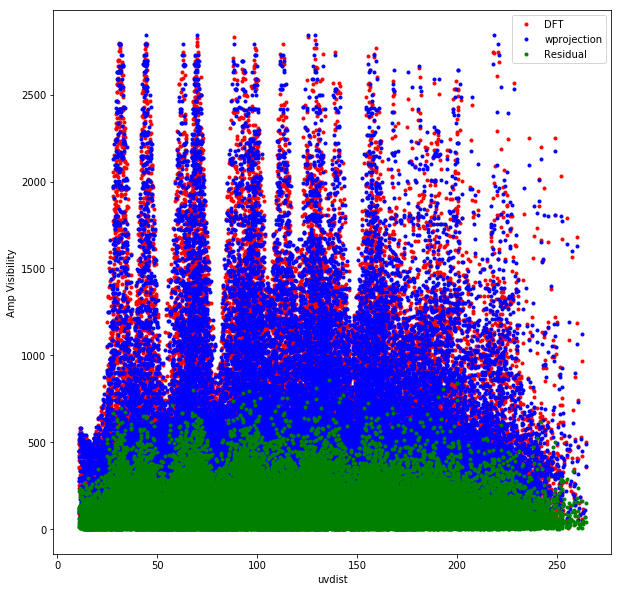

In [11]:
contexts = ['2d', 'facets', 'timeslice', 'wstack', 'wprojection']

for context in contexts:
    
    print('Processing context %s' % context)
   
    vtpredict_list =[create_visibility(lowcore, times, frequency, channel_bandwidth=channel_bandwidth,
        weight=1.0, phasecentre=phasecentre, polarisation_frame=PolarisationFrame('stokesI'))]
    model_list = [model]

 
    if context == 'wprojection':       
        future = predict_list_arlexecute_workflow(vtpredict_list, model_list, context='2d', 
                                                 wstep = advice['w_sampling_primary_beam'],
                                                oversampling=2)
    
    elif context == 'facets':
        future = predict_list_arlexecute_workflow(vtpredict_list, model_list, context=context, facets=8)
        
    elif context == 'timeslice':
        future = predict_list_arlexecute_workflow(vtpredict_list, model_list, context=context, vis_slices=vis_timeslices(
            vtpredict, 'auto'))

    elif context == 'wstack':
        future = predict_list_arlexecute_workflow(vtpredict_list, model_list, context=context, vis_slices=31)

    else:
        future = predict_list_arlexecute_workflow(vtpredict_list, model_list, context=context)
        
    vtpredict_list = arlexecute.compute(future, sync=True)
        
    vtpredict = vtpredict_list[0]

    uvdist = numpy.sqrt(vt.data['uvw'][:, 0] ** 2 + vt.data['uvw'][:, 1] ** 2)
    plt.clf()
    plt.plot(uvdist, numpy.abs(vt.data['vis'][:]), '.', color='r', label="DFT")
    
    plt.plot(uvdist, numpy.abs(vtpredict.data['vis'][:]), '.', color='b', label=context)
    plt.plot(uvdist, numpy.abs(vtpredict.data['vis'][:] - vt.data['vis'][:]), '.', color='g', label="Residual")
    plt.xlabel('uvdist')
    plt.ylabel('Amp Visibility')
    plt.legend()
    plt.show()


Make the image using the different approaches. We will evaluate the results using a number of plots:

- The error in fitted versus the radius. The ideal result is a straightline fitted: flux = DFT flux
- The offset in RA versus the offset in DEC. The ideal result is a cluster around 0 pixels.

The sampling in w is set to provide 2% decorrelation at the half power point of the primary beam.


create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 999999.99999 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
Processing context 2d
arlexecute.compute: Execution using Dask took 0.995 seconds


arlexecute.compute: Execution using Dask took 0.995 seconds


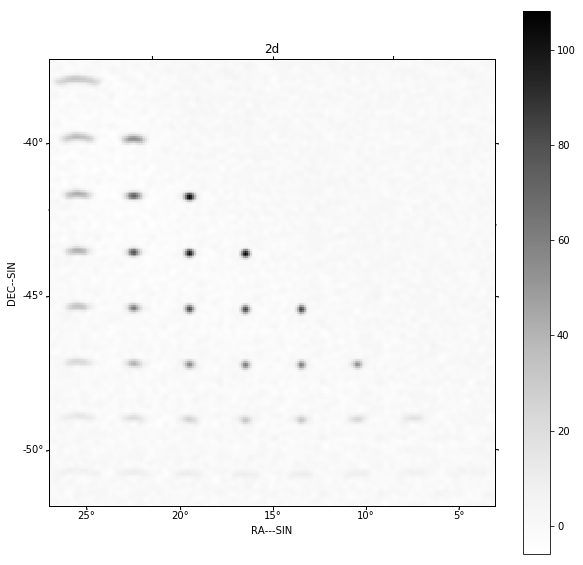

Dirty Image Quality assessment:
	Origin: qa_image
	Context: imaging-fits notebook, using processor 2d
	Data:
		shape: '(1, 1, 256, 256)'
		max: '108.25673449855343'
		min: '-6.024468601181484'
		rms: '4.925599207948631'
		sum: '3401.6857195824477'
		medianabs: '1.1533537117335797'
		median: '-0.5875479651041338'

find_skycomponents: Finding components in Image by segmentation
find_skycomponents: Identified 28 segments


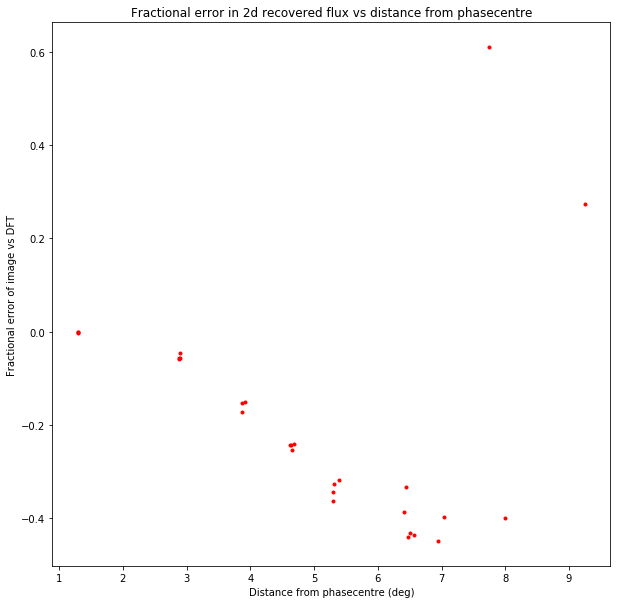

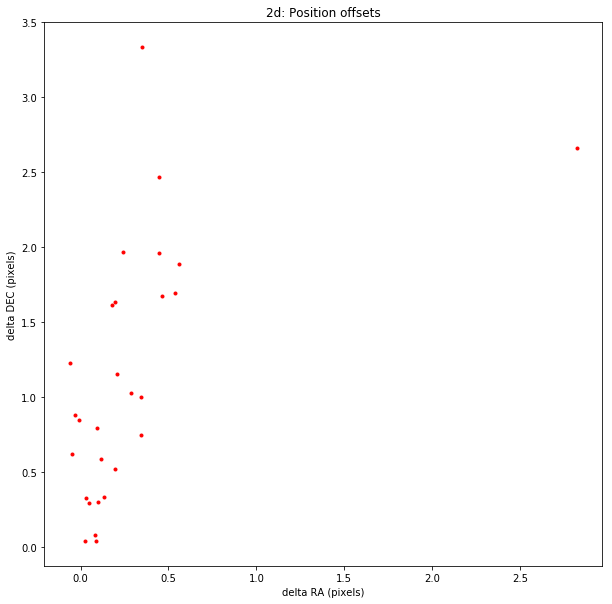

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 999999.99999 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
Processing context facets
arlexecute.compute: Execution using Dask took 12.870 seconds


arlexecute.compute: Execution using Dask took 12.870 seconds


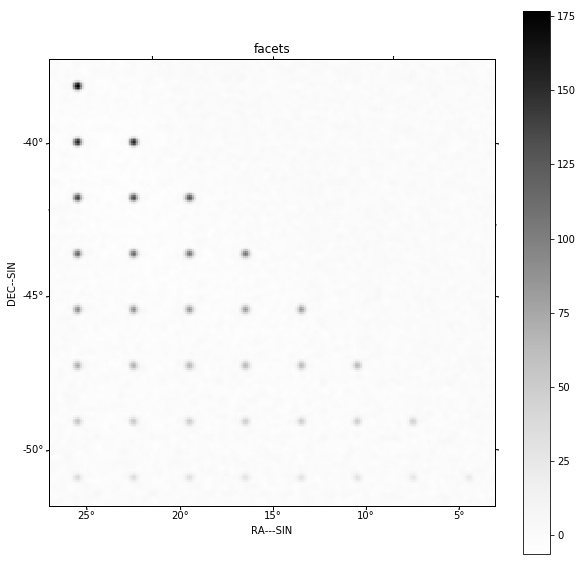

Dirty Image Quality assessment:
	Origin: qa_image
	Context: imaging-fits notebook, using processor facets
	Data:
		shape: '(1, 1, 256, 256)'
		max: '176.74729881250985'
		min: '-6.376126012405798'
		rms: '6.589422073747307'
		sum: '3603.8553850412836'
		medianabs: '1.1389334771032673'
		median: '-0.6551967742187552'

find_skycomponents: Finding components in Image by segmentation
find_skycomponents: Identified 36 segments


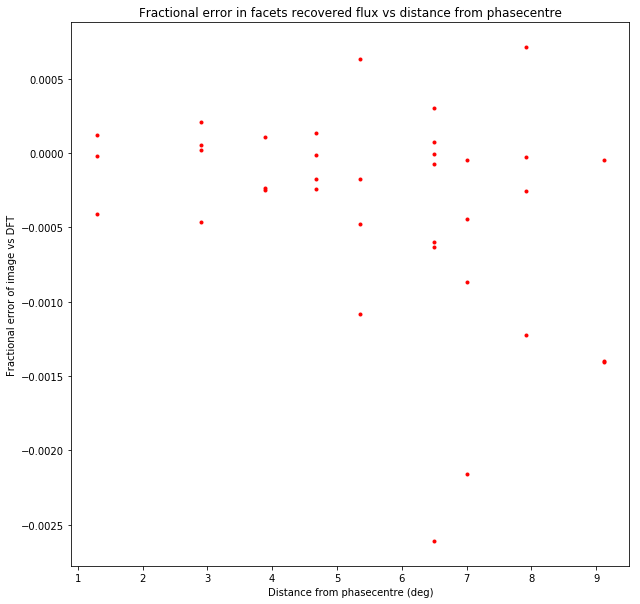

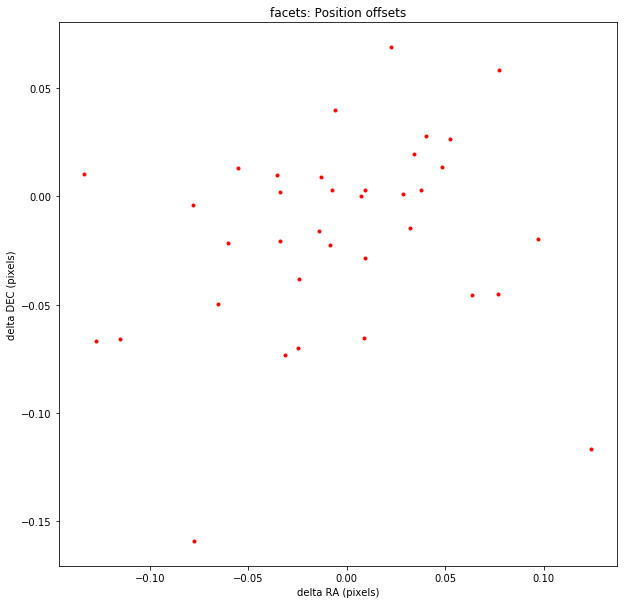

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 999999.99999 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
Processing context timeslice
arlexecute.compute: Execution using Dask took 1.885 seconds


arlexecute.compute: Execution using Dask took 1.885 seconds


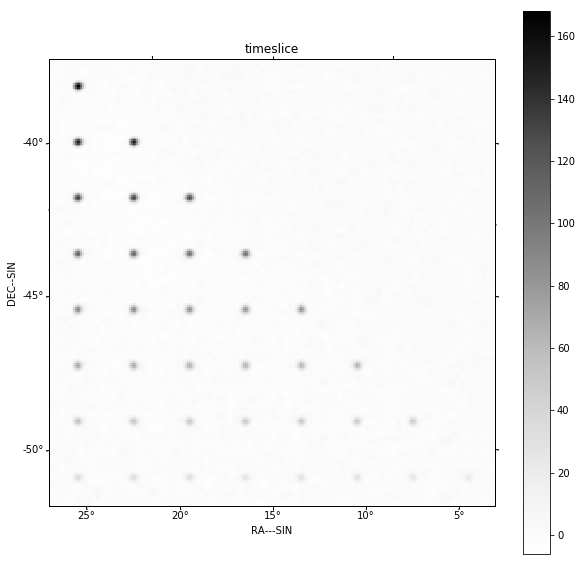

Dirty Image Quality assessment:
	Origin: qa_image
	Context: imaging-fits notebook, using processor timeslice
	Data:
		shape: '(1, 1, 256, 256)'
		max: '168.17313801313483'
		min: '-6.109855848930789'
		rms: '6.521990674295711'
		sum: '4240.96900027747'
		medianabs: '1.100839265908241'
		median: '-0.6284277120866588'

find_skycomponents: Finding components in Image by segmentation
find_skycomponents: Identified 36 segments


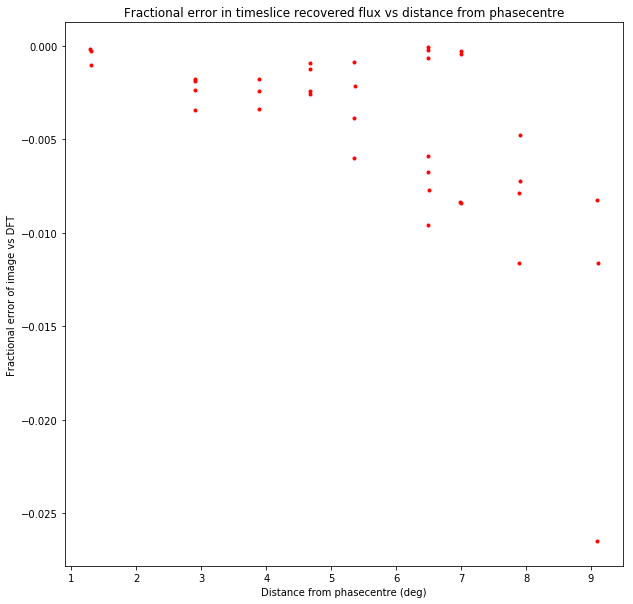

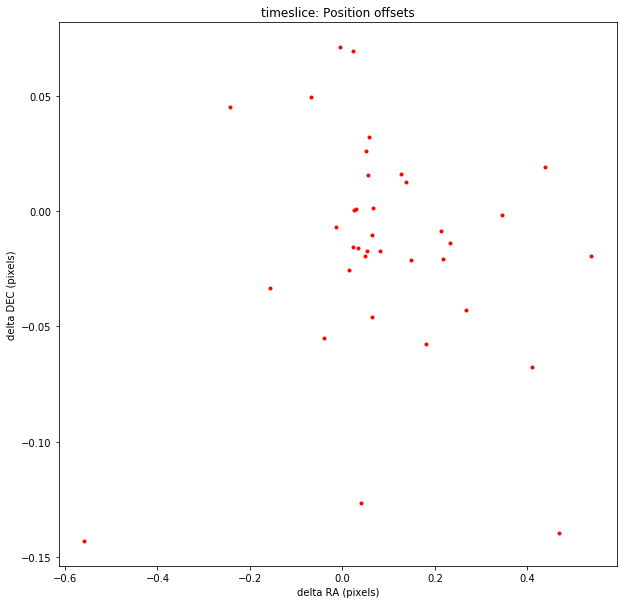

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 999999.99999 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
Processing context wstack
arlexecute.compute: Execution using Dask took 1.439 seconds


arlexecute.compute: Execution using Dask took 1.439 seconds


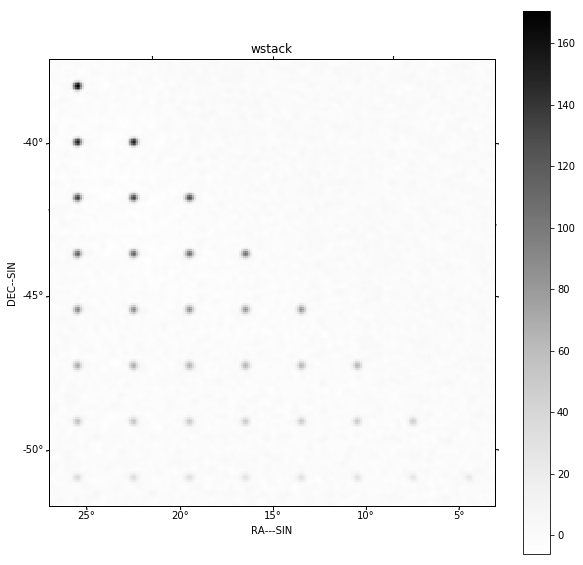

Dirty Image Quality assessment:
	Origin: qa_image
	Context: imaging-fits notebook, using processor wstack
	Data:
		shape: '(1, 1, 256, 256)'
		max: '170.5718605728621'
		min: '-6.219399896651957'
		rms: '6.518150895224886'
		sum: '3144.280856905753'
		medianabs: '1.1398193889951598'
		median: '-0.6586228769312453'

find_skycomponents: Finding components in Image by segmentation
find_skycomponents: Identified 36 segments


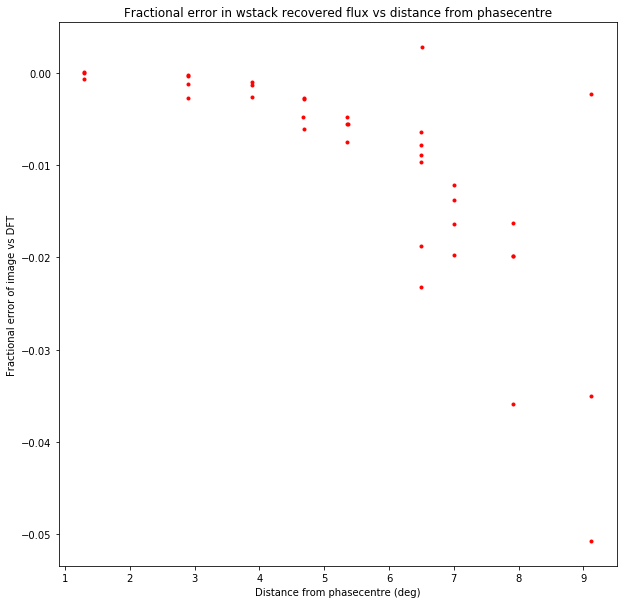

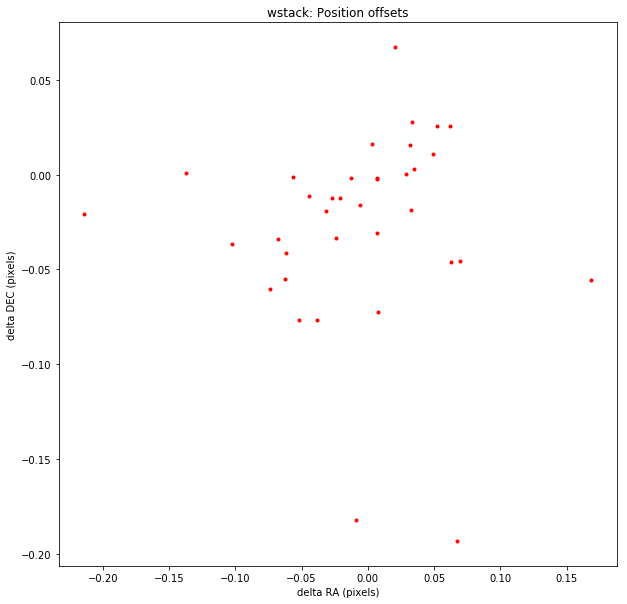

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 999999.99999 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
Processing context wprojection
arlexecute.compute: Execution using Dask took 12.517 seconds


arlexecute.compute: Execution using Dask took 12.517 seconds


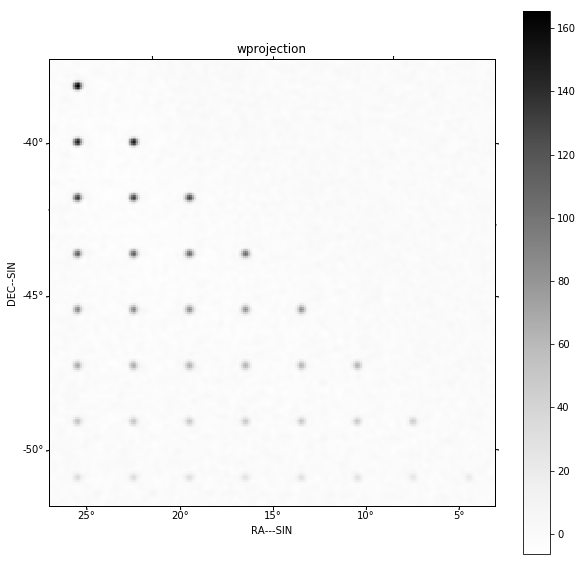

Dirty Image Quality assessment:
	Origin: qa_image
	Context: imaging-fits notebook, using processor wprojection
	Data:
		shape: '(1, 1, 256, 256)'
		max: '165.51125187560254'
		min: '-6.455795228712371'
		rms: '6.422125123051603'
		sum: '3039.113348012008'
		medianabs: '1.1255464205146826'
		median: '-0.6474152455816558'

find_skycomponents: Finding components in Image by segmentation
find_skycomponents: Identified 36 segments


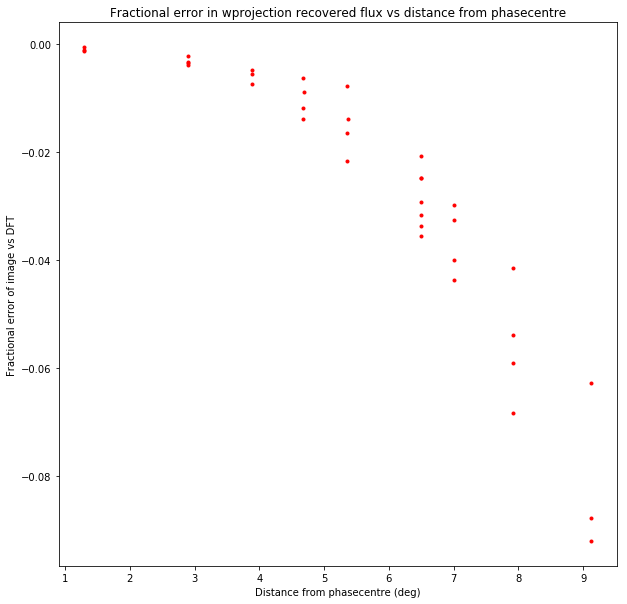

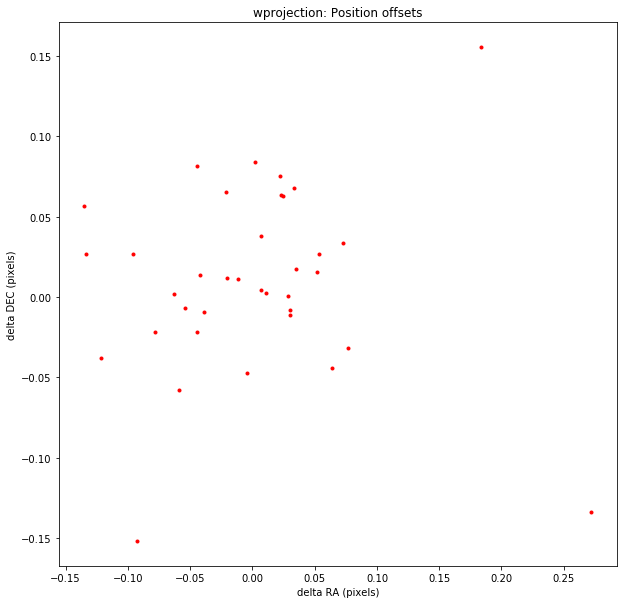

In [12]:
contexts = ['2d', 'facets', 'timeslice', 'wstack', 'wprojection']

for context in contexts:

    targetimage_list = [create_image_from_visibility(vt, npixel=npixel, cellsize=0.001, nchan=1,
                                               polarisation_frame=PolarisationFrame('stokesI'))]
    
    vt_list = [vt]


    print('Processing context %s' % context)
    if context == 'wprojection':       
        future = invert_list_arlexecute_workflow(vt_list, targetimage_list, context='2d', 
                                                         wstep = advice['w_sampling_primary_beam'],
                                                        oversampling=2)
    
    elif context == 'facets':
        future = invert_list_arlexecute_workflow(vt_list, targetimage_list, context=context, facets=8)
        
    elif context == 'timeslice':
        future = invert_list_arlexecute_workflow(vt_list, targetimage_list, context=context, vis_slices=vis_timeslices(vt, 'auto'))

    elif context == 'wstack':
        future = invert_list_arlexecute_workflow(vt_list, targetimage_list, context=context, vis_slices=31)

    else:
        future = invert_list_arlexecute_workflow(vt_list, targetimage_list, context=context)
        
    result = arlexecute.compute(future, sync=True)
    targetimage = result[0][0]

    show_image(targetimage)
    plt.title(context)
    plt.show()

    print("Dirty Image %s" % qa_image(targetimage, context="imaging-fits notebook, using processor %s" % context))

    export_image_to_fits(targetimage, '%s/imaging-fits_dirty_%s.fits' % (results_dir, context))
    comps = find_skycomponents(targetimage, fwhm=1.0, threshold=10.0, npixels=5)

    plt.clf()
    for comp in comps:
        distance = comp.direction.separation(model.phasecentre)
        dft_flux = sum_visibility(vt, comp.direction)[0]
        err = (comp.flux[0, 0] - dft_flux) / dft_flux
        plt.plot(distance, err, '.', color='r')
    plt.ylabel('Fractional error of image vs DFT')
    plt.xlabel('Distance from phasecentre (deg)')
    plt.title(
        "Fractional error in %s recovered flux vs distance from phasecentre" %
        context)
    plt.show()

    checkpositions = True
    if checkpositions:
        plt.clf()
        for i in range(len(comps)):
            ocomp, sep = find_nearest_skycomponent(comps[i].direction, original_comps)
            plt.plot(
                (comps[i].direction.ra.value - ocomp.direction.ra.value) /
                targetimage.wcs.wcs.cdelt[0],
                (comps[i].direction.dec.value - ocomp.direction.dec.value) /
                targetimage.wcs.wcs.cdelt[1],
                '.',
                color='r')

        plt.xlabel('delta RA (pixels)')
        plt.ylabel('delta DEC (pixels)')
        plt.title("%s: Position offsets" % context)
        plt.show()